# Bitcoin Marketplace Rating Predictions
Features:
- Normalized target graph features
- Difference between nomalized graph target and source
- Aggregate rating metrics target
- Aggregate rating metrics source 

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import itertools

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve


import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v
import features as f
import time

#### Import Model Features

In [2]:
# Load Data
df_historical_target = pd.read_csv('../data/historical_target_features.csv')
df_historical_source = pd.read_csv('../data/historical_source_features.csv')
df_graph_target = pd.read_csv('../data/graph_target_features.csv')    
df_graph_source = pd.read_csv('../data/graph_source_features.csv')        

In [3]:
def subset_mask(df_historical, type):
    if type == 'fraud':
        return df_historical[(df_historical['num_neg_received']==0) & 
                             (df_historical['num_pos_received']>=3) & 
                             ((df_historical['rating']>0) | (df_historical['rating']==-10))]    
    elif type == 'suspicious':
        return df_historical[(df_historical_target['num_neg_received']==0) & 
                             (df_historical_target['num_pos_received']>=3) &
                             (df_historical['rating']>-10)]    
    elif type == 'all':
        return df_historical[(df_historical_target['num_neg_received']==0) & 
                             (df_historical_target['num_pos_received']>=3)]
    else:
        return df_historical

In [4]:
mask = subset_mask(df_historical_target, "none")
merge_cols = ['ratee','rater','date','rating']

df_gs = f.normalize_source_graph_metrics(df_graph_source)
df_gt = f.normalize_target_graph_metrics(df_graph_target)

df_gt.drop(['color', 'penwidth'], inplace=True, axis=1)
df_gs.drop(['color', 'penwidth'], inplace=True, axis=1)
df_historical_target.drop(['color', 'penwidth'], inplace=True, axis=1)
df_historical_source.drop(['color', 'penwidth'], inplace=True, axis=1)

df_lst = [df_historical_target, df_historical_source]
df_hh = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), df_lst)
df_hh = df_hh[df_hh.index.isin(mask.index)]

df_lst = [df_gt, df_gs]
df_g = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), df_lst)
df_gg = f.graph_metrics_source_target_difference(df_g)
df_gg = df_gg[df_gg.index.isin(mask.index)]

df_lst= [df_hh, df_gg]
df_all = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), df_lst)  

In [5]:
xf_coef = df_gg[df_gg['rating']==-10]['cluster_coef_target']
xl_coef = df_gg[df_gg['rating']==1]['cluster_coef_target']

# probably not going to use this one
xf_c = df_all[df_all['rating']==-10]['closeness_target']
xl_c = df_all[df_all['rating']==1]['closeness_target']

xf_b = df_all[df_all['rating']==-10]['betweeness_target']
xl_b = df_all[df_all['rating']==1]['betweeness_target']

fig, axs = plt.subplots(1,3, figsize=(16, 4))
n_bins = 500

# plot the cumulative histogram
axs[0].hist(xf_coef, n_bins, density=True, histtype='step',
                           cumulative=True, label='Fraud')
axs[0].hist(xl_coef, n_bins, density=True, histtype='step',
                           cumulative=True, label='Legit')

axs[1].hist(xf_c, n_bins, density=True, histtype='step',
                           cumulative=True, label='Fraud')
axs[1].hist(xl_c, n_bins, density=True, histtype='step',
                           cumulative=True, label='Legit')

axs[2].hist(xf_b, n_bins, density=True, histtype='step',
                           cumulative=True, label='Fraud')
axs[2].hist(xl_b, n_bins, density=True, histtype='step',
                           cumulative=True, label='Legit')

axs[0].set_xlabel("Cluster Coefficient")
axs[1].set_xlabel("Closeness Metric")
axs[2].set_xlabel("Betweeness Metric")

axs[0].legend()
# ax.set_title("Percentage that will be Fraud or Legit as Value Increase")
axs[0].legend(loc='lower right')
axs[0].set_xlim(0,1)
axs[0].set_ylabel('Likelihood of Occurrence')
plt.tight_layout

KeyError: 'closeness_target'

### Fit and Predict Feature Categories

In [ ]:
# tuned model
model_tuned = RandomForestClassifier(bootstrap = True,
                                     max_depth = 55,
                                     max_features = 5,
                                     min_samples_leaf = 1,
                                     min_samples_split = 3,
                                     n_estimators = 1800,
                                     n_jobs=-1,
                                     random_state=123)

In [6]:
def predict_on_features(df):
    X = df.copy()
    y = np.where(X['rating']<0, 1, 0)
    X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    random_state=123)
    model = RandomForestClassifier(n_jobs=-1, random_state=123)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba)
    fpr, tpr, threshold = roc_curve(y_test, proba)
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    thresh = 0.2
    cnf_matrix = confusion_matrix(y_test, proba>=thresh)
#     print(len(y_test[y_test==1]), len(y_train[y_train==1]))

        
    y_hats_df = pd.DataFrame(data = proba, columns = ['y_hats'], index = X_test.index.copy())
    df_out = pd.merge(df, y_hats_df, how = 'left', left_index = True, right_index = True)
    
    return pred, proba, precision, recall, thresholds, f1, cnf_matrix, fpr, tpr, threshold, accuracy, model, X_test, y_test, df_out 
    return pred, proba, precision, recall, thresholds, f1, cnf_matrix, fpr, tpr, threshold, accuracy, model 

In [7]:
a_pred, a_proba, a_precision, a_recall, a_thresholds, a_f1, a_cm, a_fpr, a_tpr, a_threshold, a_accuracy, a_model, X_test, y_test, df_out = predict_on_features(df_all)
X_test['prediction'] = a_proba

In [9]:
X_test[y_test==1].head()

,num_ratings_received,num_neg_received,num_pos_received,neg_ratings_pct,rating_received_sum,rating_received_avg,days_since_first_rating_target,days_since_last_rating_target,last_rating_neg,num_ratings_given,rating_given_avg,days_since_first_rating_source,days_since_last_rating_source,triad_030C_target,cluster_coef_target,neighbors_in_target,betweeness_target,excess_ratings_in_target,210_norm_target,120_norm_target,300_norm_target,030T_norm_target,201_norm_target,111_norm_target,102_norm_target,021_norm_target,all_norm_target,triad_030C_source,neighbors_in_diff,210_diff,120_diff,300_diff,030T_diff,201_diff,111_diff,102_diff,021_diff,triads_diff,betweeness_diff,excess_ratings_in_diff,cluster_coef_diff,prediction
23620,4.0,3.0,1.0,0.750000,-11.0,-2.750000,11.0,0.0,1.0,20.0,0.700000,594.0,31.0,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-16.0,-1.235294,-0.882353,-0.764706,-0.058824,-4.705882,-4.176471,-9.000000,-0.705882,-48.000000,-0.599580,-0.294118,-0.159898,0.97
16347,10.0,1.0,9.0,0.100000,10.0,1.000000,36.0,2.0,0.0,16.0,0.500000,51.0,8.0,0.0,0.010101,9.0,0.652778,0.333333,0.0,0.111111,0.000000,0.0,1.666667,1.888889,0.000000,0.333333,13.333333,0.0,-1.0,-0.500000,0.111111,-0.400000,0.000000,-2.333333,1.488889,-2.000000,0.033333,-3.166667,-0.169444,0.333333,-0.112121,0.22
31633,3.0,2.0,1.0,0.666667,-19.0,-6.333333,2.0,0.0,1.0,369.0,-2.750678,667.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,-179.0,-4.638889,-2.072222,-4.733333,-0.450000,-86.327778,-57.511111,-451.333333,-10.850000,-5399.833333,-0.645682,-0.272222,-0.039689,1.00
30148,5.0,3.0,2.0,0.600000,-19.0,-3.800000,6.0,0.0,1.0,237.0,0.059072,928.0,0.0,0.0,0.000000,2.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.500000,1.0,-203.0,-2.804878,-0.741463,-4.229268,-0.078049,-91.514634,-50.214634,-521.917073,-7.439024,-7003.500000,0.273168,-0.224390,-0.036119,0.80
15258,12.0,0.0,12.0,0.000000,30.0,2.500000,505.0,492.0,0.0,51.0,-1.843137,115.0,0.0,0.0,0.015152,12.0,0.984848,0.000000,0.0,0.000000,0.083333,0.0,5.416667,0.000000,0.833333,0.000000,23.833333,0.0,-10.0,-0.227273,-0.090909,-0.053030,-0.045455,-1.674242,-3.136364,-3.803030,-0.363636,-56.666667,0.130736,-0.181818,-0.017001,0.86


In [ ]:
X_test[(y_test==1) & (X_test['days_since_first_rating_target']==0) & (X_test['days_since_first_rating_source']==0)].sort_values('prediction', ascending=False)

In [7]:
hh_pred, hh_proba, hh_precision, hh_recall, hh_thresholds, hh_f1, hh_cm, hh_fpr, hh_tpr, hh_threshold, hh_accuracy, hh_model = predict_on_features(df_hh)
gg_pred, gg_proba, gg_precision, gg_recall, gg_thresholds, gg_f1, gg_cm, gg_fpr, gg_tpr, gg_threshold, gg_accuracy, gg_model = predict_on_features(df_gg)
a_pred, a_proba, a_precision, a_recall, a_thresholds, a_f1, a_cm, a_fpr, a_tpr, a_accuracy, a_threshold, a_model = predict_on_features(df_all)

#### ROC AUC Plot

In [8]:
def roc_curve(ax):
    ax.set_title('Receiver Operating Characteristic')
    ax.plot(gg_fpr, gg_tpr, 'r', label = f"Graph Features f1: {gg_f1:.2f} AUC:{auc(gg_fpr, gg_tpr):.2f}")
    ax.plot(hh_fpr, hh_tpr, 'g', label = f"Ratings Features f1: {hh_f1:.2f} AUC: {auc(hh_fpr, hh_tpr):.2f}")
    ax.plot(a_fpr, a_tpr, 'b', label = f"All Features (f1: {a_f1:.2f} AUC: {auc(a_fpr, a_tpr):.2f}")
    ax.legend(loc = 'lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

#### Precision Recall Curve

In [9]:
def pr_curve(ax):
    ax.set_title("Precision Recall Curve")
    ax.plot(gg_recall, gg_precision, alpha=0.8, c='r')
    ax.plot(hh_recall, hh_precision, alpha=0.8, c='g')
    ax.plot(a_recall, a_precision, alpha=0.8, c='b')
    
    thresh = 0.2
    threshold_idx = np.argmin(np.abs(a_thresholds-thresh))
    ax.plot(a_recall[threshold_idx], 
            a_precision[threshold_idx],  
            'o', c='b', markersize=8, fillstyle='full', 
             label=f"{thresh:.2f} threshold", mew=2)               

    threshold_idx = np.argmin(np.abs(gg_thresholds-thresh))
    ax.plot(gg_recall[threshold_idx], 
            gg_precision[threshold_idx],  
            'o', c='r', markersize=8, fillstyle='full', 
             label=f"{thresh:.2f} threshold", mew=2)               

    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left", frameon=False)

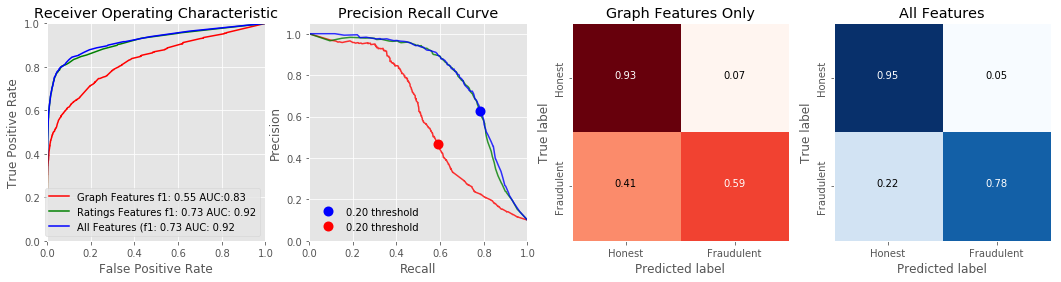

In [10]:
fig, axs = plt.subplots(1,4,figsize=(18,4))
roc_curve(axs[0])
pr_curve(axs[1])
v.plot_confusion_matrix(axs[2], gg_cm, 
                      classes=['Honest','Fraudulent'], 
                      normalize=True,
                      title='Graph Features Only',
                      cmap=plt.cm.Reds)

v.plot_confusion_matrix(axs[3], a_cm, 
                      classes=['Honest','Fraudulent'], 
                      normalize=True,
                      title='All Features')
plt.show()

In [11]:
X_test[(X_test['prediction']>.25) & (y_test==1)].sort_values('prediction').head()

NameError: name 'X_test' is not defined

### Feature Importance

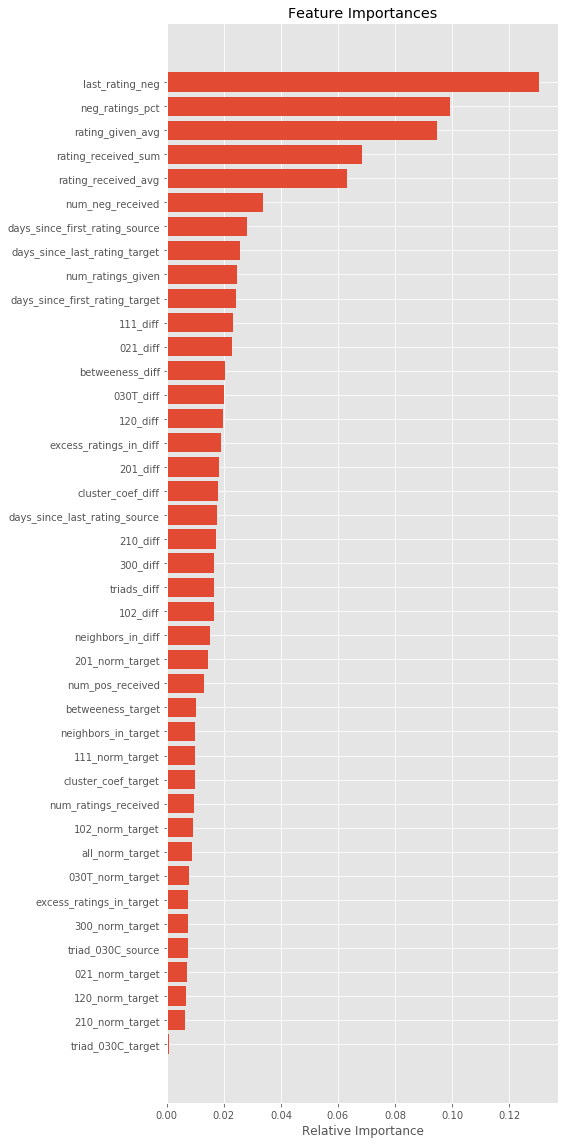

In [12]:
X = df_all.copy()
X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
features=X.columns
importances = a_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8,16))
ax.set_title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()

### Collusion Example

In [ ]:
X_test[y_test==1]

In [ ]:
# Predict on Example 
x_pred = features_df[(features_df['ratee']==4986)].copy()
model = RandomForestClassifier(n_jobs=-1,
                               random_state=123)
model.fit(X_train, y_train)
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date', 'class'], axis=1, inplace=True)

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features

In [ ]:
# Predict on Example (with no features)
model_ng = RandomForestClassifier(n_jobs=-1,
                                  random_state=123)
model_ng.fit(X_train, y_train)
x = features_df_ng[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date', 'class'], axis=1, inplace=True)

In [ ]:
x_pred = features_df_ng[(features_df_ng['ratee']==4986)].copy()

x = x_pred.drop(['rater', 'ratee', 'rating','date'], axis=1)
y = x.pop('class')

# run model without graph features
pred_no_features = model_ng.predict_proba(x)[:,1]
x_pred = x_pred[['ratee','date','rating']]
x_pred['prediction_without_features'] = pred_no_features

In [ ]:
# rerun model with graph features
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date'], axis=1, inplace=True)
y = x.pop('class')

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features
x_pred